# Entrega 1


Comenzando desde la base de lo desarrollado en la exploración de los datos, implementaremos nuestra propia versión de K-Means, debido a que este algoritmo necesita un trato especial para datos no-numéricos (en particular discretos).

Esta versión de K-Means consistirá en el K-Means clásico, pero que acepta una función de distancia arbitraria y una función de actualización de centroide arbitraria. Debido a que estamos en un ámbito discreto, el centroide nuevo será uno de los puntos del cluster.

In [1]:
import random
from itertools import groupby
######################################
#       Discrete K-Means Model       #
######################################

class DiscreteKMeans():
    def __init__(self, n_clusters, distance_fun):
        '''Constructor for the model.
        ----------
        Parameters:
            n_clusters:
                number of clusters to create.
            distance_fun:
                callable that takes two instances of the observations intended for this model.
                returns the distance between the instances in the model.
        ''' 
        self.n_clusters = n_clusters
        self.distance_fun = distance_fun
        
    def centroid_fun(self, cluster, new_centroids = []):
        '''Recalculates the centroid for a given cluster. Given the centroid already recalculated
        in this iteration.
        ----------
        Parameters:
            cluster:
                items containes in the cluster.
            new_centroids:
                centroids already calculated in this iteration.
        '''
        # Generate a list that contains, for every point in the cluster, the squares sum of distances.
        inner_distances = list(map(
            lambda item: sum(
                map(lambda item2: (self.distance_fun(item, item2) ** 2) * self.frequencies[item2], cluster)
            ),
            cluster
        ))
        
        # Assign a centroid and check its unique
        centroid = cluster[inner_distances.index(min(inner_distances))]
        while centroid in new_centroids:
            inner_distances.remove(min(inner_distances))
            centroid = cluster[inner_distances.index(min(inner_distances))]
        return centroid
        
    
    def fit(self, observations, max_iter = 100):
        '''Trains the model with the given data.
        ----------
        Parameters:
            observations: arraylike of objects.
        '''
        # Here we generate a mapping of session to frequency, to help in reducing repeated calculations
        # of the same distances, and simply multiplying each distance by the sessions frequency.
        self.frequencies = {session: len(list(frequency)) for session, frequency in groupby(observations)}
        
        observations = set(observations)
        
        # The algorithm starts by selecting the initial centroids randomly.
        self.centroids = random.sample(observations, k =self.n_clusters)
        
        self.clusters = dict.fromkeys(self.centroids, [])
        
        # Training loop
        n_iter = 0
        while(n_iter < max_iter):
            n_iter += 1
            print("Iteration {}: {}".format(n_iter, self.centroids))
            
            # Assign every observation to the closest cluster.
            for item in observations:
                centroid_distances = list(
                    map(
                        lambda centroid: self.distance_fun(item, centroid) * self.frequencies[item], 
                        self.centroids
                    )
                )
                nearest_centroid = self.centroids[centroid_distances.index(min(centroid_distances))]
                self.clusters[nearest_centroid].append(item)
                
            # Recalculate the centroids based on centroid_fun.
            new_clusters = {}
            for centroid, cluster in self.clusters.items():
                new_centroid = self.centroid_fun(cluster, list(new_clusters.keys()))
                new_clusters[new_centroid] = self.clusters[centroid]
            
            # If centroids didn't change, then continue.
            if self.centroids == list(new_clusters.keys()):
                break
            
            # To continue, change the instance centroids, and erase the contents of every cluster
            self.centroids = list(new_clusters.keys())
            self.clusters = dict.fromkeys(self.centroids, [])
            
    def wcs(self):
        '''Returns the within cluster sum of squares as a dictionary. with each centroid being a key.
        '''
        distances = dict.fromkeys(self.clusters.keys())
        for centroid, cluster in self.clusters.items():
            distances[centroid] = sum(map(lambda item: self.distance_fun(item, centroid) ** 2, cluster))
        return distances
    
    def wcss(self):
        '''Returns the sum of the within cluster sum of squares along the whole model.
        '''
        return sum(list(self.wcs().values()))
    
    def bcs(self):
        '''Returns the between cluster squares.
        '''
        general_centroid = self.centroid_fun([item for cluster in self.clusters.values() for item in cluster])
        distances = dict.fromkeys(self.clusters.keys())
        for centroid in self.clusters.keys():
            distances[centroid] = self.distance_fun(general_centroid, centroid) ** 2
        return distances
    
    def bcss(self):
        '''Returns the sum of between cluster squares distance along all clusters.
        '''
        return sum(list(self.bcs().values()))

Con este modelo realizamos una clusterización de los datos.

In [2]:
import MySQLdb as mdb
import pandas as pd

con = mdb.connect("127.0.0.1", "guidecapture", "guidecapture", "guide_informe_final_corfo")
with con:
    cur = con.cursor()
    cur.execute("SELECT id, sequence, user_id, inittime, endtime FROM sessions;")
    rows = cur.fetchall()
    df = pd.DataFrame([[attribute for attribute in session] for session in rows])
    df.rename(columns={0:"id", 1:"sesión", 2:"usuario", 3:"inittime", 4:"endtime"}, inplace=True)

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: context interface will be changed.  Use explicit conn.commit() or conn.rollback().
  """


,id,sesión,usuario,inittime,endtime
0,1,1 19,1,2016-05-12 10:12:04,2016-05-12 10:13:27
1,2,19,1,2016-05-12 10:15:17,2016-05-12 10:16:27
2,3,19 1 1 19 19,1,2016-05-12 10:18:28,2016-05-12 10:21:28
3,4,1,1,2016-05-12 11:03:31,2016-05-12 11:03:38
4,5,1 14 14 1 1 32 32,1,2016-05-12 11:07:12,2016-05-12 11:11:36


In [3]:
import numpy as np

# Transforms a session string into a dictionary containing the number of visits for each page in the session.
def total_visits(session):
    visits = session.split(" ")
    total_visits = {}
    for v in visits:
        if v in total_visits:
            total_visits[v] += 1
        else:
            total_visits[v] = 1
    return total_visits

# Distance function for the clustering algorithm.
def jaccard(s1, s2):
    s1_visits, s2_visits = total_visits(s1), total_visits(s2)
    all_pages = set(list(s1_visits.keys()) + list(s2_visits.keys()))
    intersection = 0
    union = len(all_pages)
    for key in all_pages:
        if key in s1_visits and key in s2_visits:
            intersection += 1
    return 1 - intersection / union

Para evaluar el número de clusters óptimos graficamos la distancia entre clusters máxima.

In [4]:
wcsss = []
for i in range(10):
    print("K-Means: {}".format(i + 1))
    dkm = DiscreteKMeans(i + 1, jaccard)
    dkm.fit(df["sesión"])
    wcsss.append(dkm.wcss())
    
print(wcsss)

K-Means: 1
Iteration 1: ['6 21']
Iteration 2: ['1 21 20 19 19 34 34 25']
K-Means: 2
Iteration 1: ['1 21 21 22 27 27 11 11 19 19 34', '1 19 19 34 34 6 6 19 19']
Iteration 2: ['1 21 20 19 19 34 34 25', '1 21 21 19 19 34 20']
K-Means: 3
Iteration 1: ['20 27 20 20 27 20 20 27 27 20 20', '25 34 25 34 25 34 25 25 34 25 34 34 27 27', '25 24']
Iteration 2: ['1 21 20 19 19 34 34 25', '1 21 21 19 19 34 20', '20 1 1 19 25 34']
K-Means: 4
Iteration 1: ['25 34 34 25 25 34 25 25 23 23 25', '34 1 19 19', '21 1 14 16', '28 20 20 28 28']
Iteration 2: ['1 21 20 19 19 34 34 25', '1 21 21 19 19 34 20', '20 1 1 19 25 34', '20 25 34 25 25 19 19 1 11']
K-Means: 5
Iteration 1: ['8 34 24', '28', '24 6 6 31', '1 19 19 34 24 24 19 6 6 19 19 16 19', '27 20 20 27']
Iteration 2: ['1 21 20 19 19 34 34 25', '1 21 21 19 19 34 20', '20 1 1 19 25 34', '20 25 34 25 25 19 19 1 11', '1 19 34 34 20 34']
K-Means: 6
Iteration 1: ['29 19 19 23 19', '1 19 19 11 11 6 6 21 21 16', '22 11 11 25 25', '31 14 14 6 6 1 1 6 6 14 6 14 1

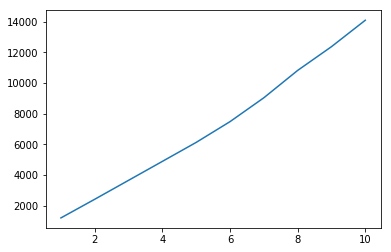

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11), wcsss)
plt.show()

Podemos ver que la suma de distancias entre puntos de cada cluster no es una métrica que nos dice mucho sobre el clustering generado. 